In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from random import randrange
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
from math import log

# Import data

In [2]:
df = pd.read_json('rating_per_user.json', orient='records', lines=True)
df.head()

,ratingType,ratings,ratings_date,nof_reviews
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24


# Exploratory data analysis

There are two ways of analysing these data: user level (each row represents a user) and rating level (each row represents a rating).

## User level

In [3]:
# General exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206396 entries, 0 to 206395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ratingType    206396 non-null  object
 1   ratings       206396 non-null  object
 2   ratings_date  206396 non-null  object
 3   nof_reviews   206396 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.3+ MB


In [4]:
# Exploration of ratingType
df['ratingType'].value_counts()

SellerToBuyer    124552
BuyerToSeller     81844
Name: ratingType, dtype: int64

In [5]:
# Exploration of nof_reviews
df['nof_reviews'].describe()

count    206396.000000
mean          1.038431
std           0.435590
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          86.000000
Name: nof_reviews, dtype: float64

In [6]:
pd.pivot_table(df,
               values='ratings',
               index='nof_reviews',
               columns='ratingType',
               aggfunc=['count'],
               margins=True
               )

count                      
ratingType  BuyerToSeller SellerToBuyer     All
nof_reviews                                    
1                 79945.0      121218.0  201163
2                  1471.0        2704.0    4175
3                   221.0         375.0     596
4                    86.0         107.0     193
5                    35.0          47.0      82
6                    22.0          29.0      51
7                    20.0          22.0      42
8                    15.0          18.0      33
9                     6.0           6.0      12
10                    6.0           7.0      13
11                    2.0           3.0       5
12                    2.0           2.0       4
13                    1.0           1.0       2
14                    1.0           1.0       2
15                    2.0           3.0       5
17                    1.0           1.0       2
18                    1.0           NaN       1
19                    2.0           3.0       5
20                    1.0           NaN       1
22                    NaN           1.0       1
23                    1.0           1.0       2
24                    1.0           1.0       2
28                    NaN           1.0       1
29                    1.0           NaN       1
85                    1.0           NaN       1
86                    NaN           1.0       1
All               81844.0      124552.0  206396

In [7]:
# Feature creation 1
df['rating_avg'] = df['ratings'].apply(sum)/df['nof_reviews']
df['max_rating'] =  df['ratings'].apply(max)
df['min_rating'] =  df['ratings'].apply(min)
df['max_date'] =  df['ratings_date'].apply(max)
df['min_date'] =  df['ratings_date'].apply(min)
df['score<5'] = df['rating_avg'] < 5.0
df['>1review'] = df['nof_reviews'] >1

In [8]:
# Change data types
df['max_date'] = pd.to_datetime(df['max_date'], format='%Y-%m-%d', errors='ignore')
df['min_date'] = pd.to_datetime(df['min_date'], format='%Y-%m-%d', errors='ignore')
df['max_rating'] = df['max_rating'].astype(int)
df['min_rating'] = df['min_rating'].astype(int)

In [9]:
# Feature creation 2
df['date_range'] = df['max_date'] - df['min_date']
df['rating_range'] = df['max_rating'] - df['min_rating']
df['days_range'] = df['date_range'].dt.days
df['ratings_per_day'] = df['nof_reviews'] / df['days_range']

In [10]:
# % of users per number of reviews received
df['nof_reviews'].value_counts()/sum(df['nof_reviews'].value_counts())*100

1     97.464583
2      2.022811
3      0.288765
4      0.093510
5      0.039729
6      0.024710
7      0.020349
8      0.015989
10     0.006299
9      0.005814
19     0.002423
15     0.002423
11     0.002423
12     0.001938
13     0.000969
14     0.000969
17     0.000969
23     0.000969
24     0.000969
85     0.000485
18     0.000485
20     0.000485
22     0.000485
28     0.000485
29     0.000485
86     0.000485
Name: nof_reviews, dtype: float64

In [11]:
# % of users per number of reviews received with more than 1 review
df_reviews = df[df['>1review']==True]
df_reviews['nof_reviews'].value_counts()/sum(df_reviews['nof_reviews'].value_counts())*100

2     79.782152
3     11.389260
4      3.688133
5      1.566979
6      0.974584
7      0.802599
8      0.630613
10     0.248423
9      0.229314
11     0.095547
15     0.095547
19     0.095547
12     0.076438
13     0.038219
24     0.038219
23     0.038219
17     0.038219
14     0.038219
85     0.019109
28     0.019109
18     0.019109
20     0.019109
22     0.019109
86     0.019109
29     0.019109
Name: nof_reviews, dtype: float64

In [12]:
pd.pivot_table(df_reviews,
               values='ratings',
               index='nof_reviews',
               columns='ratingType',
               aggfunc=['count'],
               margins=True
               )

count                    
ratingType  BuyerToSeller SellerToBuyer   All
nof_reviews                                  
2                  1471.0        2704.0  4175
3                   221.0         375.0   596
4                    86.0         107.0   193
5                    35.0          47.0    82
6                    22.0          29.0    51
7                    20.0          22.0    42
8                    15.0          18.0    33
9                     6.0           6.0    12
10                    6.0           7.0    13
11                    2.0           3.0     5
12                    2.0           2.0     4
13                    1.0           1.0     2
14                    1.0           1.0     2
15                    2.0           3.0     5
17                    1.0           1.0     2
18                    1.0           NaN     1
19                    2.0           3.0     5
20                    1.0           NaN     1
22                    NaN           1.0     1
23                    1.0           1.0     2
24                    1.0           1.0     2
28                    NaN           1.0     1
29                    1.0           NaN     1
85                    1.0           NaN     1
86                    NaN           1.0     1
All                1899.0        3334.0  5233

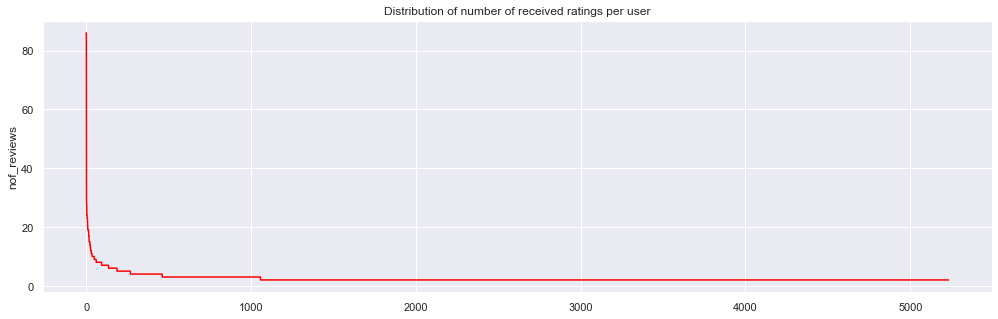

In [13]:
# Distribution of number of reviews received (linear scale)
sns.set()
plt.figure(figsize=(17, 5))
plt.plot(df_reviews['nof_reviews'], color='red')
#plt.xlim(left=-10, right=6000)
plt.title('Distribution of number of received ratings per user')
plt.ylabel('nof_reviews')
plt.yscale('linear')
plt.show()

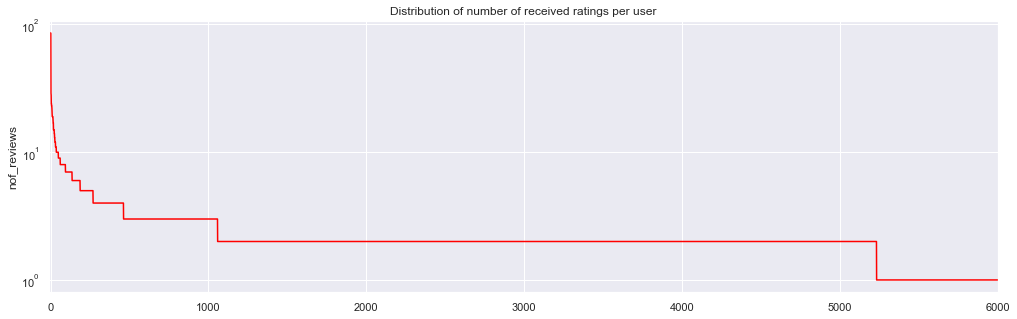

In [14]:
# Distribution of number of reviews received (logarithmic scale)
plt.figure(figsize=(17, 5))
plt.plot(df['nof_reviews'], color='red')
plt.xlim(left=-10, right=6000)
plt.title('Distribution of number of received ratings per user')
plt.ylabel('nof_reviews')
plt.yscale('log')
plt.show()

In [15]:
# Exploration of average rating per user
df['rating_avg'].describe()

count    206396.000000
mean          4.904675
std           0.498043
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating_avg, dtype: float64

In [16]:
pd.pivot_table(df,
               values='ratings',
               index='rating_avg',
               columns='ratingType',
               aggfunc=['count'],
               margins=True
               )

count                      
ratingType         BuyerToSeller SellerToBuyer     All
rating_avg                                            
1.0                       1343.0         956.0    2299
1.25                         1.0           NaN       1
1.5                          1.0           NaN       1
1.6666666666666667           1.0           1.0       2
2.0                        256.0         233.0     489
2.3333333333333335           1.0           NaN       1
2.5                          1.0           2.0       3
2.8                          NaN           1.0       1
3.0                        670.0         743.0    1413
3.5                          5.0           4.0       9
3.6666666666666665           2.0           1.0       3
4.0                       2294.0        3823.0    6117
4.333333333333333            NaN           3.0       3
4.5                         13.0          27.0      40
4.555555555555555            NaN           1.0       1
4.666666666666667            3.0           4.0       7
4.833333333333333            1.0           NaN       1
5.0                      77252.0      118753.0  196005
All                      81844.0      124552.0  206396

In [17]:
# Average rating per user and transaction
user_avg_rating = sum(df['rating_avg'])/len(df['rating_avg'])
transaction_avg_rating = sum(df['ratings'].apply(sum))/sum(df['nof_reviews'])
print('Average rating per user:', round(user_avg_rating, 3),
     '\nAverage rating per transaction:', round(transaction_avg_rating, 3))

Average rating per user: 4.905 
Average rating per transaction: 4.906


In [18]:
# Average rating per ratingType
df[['ratingType','rating_avg']].groupby(by="ratingType").mean()

,rating_avg
ratingType,
BuyerToSeller,4.880167
SellerToBuyer,4.920779


In [19]:
# Exploration of the rating average for users with 1 review and more than 1 review
pd.pivot_table(df,
               values='rating_avg',
               index='>1review',
               columns='ratingType',
               aggfunc=['mean'],
               margins=True
               )

mean                        
ratingType BuyerToSeller SellerToBuyer       All
>1review                                        
False           4.878992      4.920144  4.903789
True            4.929656      4.943868  4.938711
All             4.880167      4.920779  4.904675

In [20]:
# Exploration of the number of received ratings for users with rating average of 5 and below 5
pd.pivot_table(df,
               values='nof_reviews',
               index='score<5',
               columns='ratingType',
               aggfunc=['mean'],
               margins=True
               )

mean                        
ratingType BuyerToSeller SellerToBuyer       All
score<5                                         
False           1.038730      1.039418  1.039147
True            1.020906      1.028108  1.024925
All             1.037730      1.038891  1.038431

In [21]:
# First and last transaction dates
print('First date:',min(df['min_date']),'\nLast date:',max(df['max_date']))

First date: 2021-01-01 00:00:00 
Last date: 2021-02-14 00:00:00


## Rating level

The data are transformed so that a row represents a rating/transaction instead of a user.

In [22]:
df_2 = df.apply(pd.Series.explode)

In [23]:
df_2.head(90)

,ratingType,ratings,ratings_date,nof_reviews,rating_avg,max_rating,min_rating,max_date,min_date,score<5,>1review,date_range,rating_range,days_range,ratings_per_day
0,SellerToBuyer,5,2021-01-27,86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158
0,SellerToBuyer,5,2021-01-13,86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158
0,SellerToBuyer,5,2021-01-13,86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158
0,SellerToBuyer,5,2021-02-06,86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158
0,SellerToBuyer,5,2021-02-06,86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,SellerToBuyer,5,2021-01-07,86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158
1,BuyerToSeller,5,2021-01-09,85,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.236842
1,BuyerToSeller,5,2021-01-09,85,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.236842
1,BuyerToSeller,5,2021-01-09,85,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.236842


In [24]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214328 entries, 0 to 206395
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   ratingType       214328 non-null  object         
 1   ratings          214328 non-null  object         
 2   ratings_date     214328 non-null  object         
 3   nof_reviews      214328 non-null  int64          
 4   rating_avg       214328 non-null  float64        
 5   max_rating       214328 non-null  int32          
 6   min_rating       214328 non-null  int32          
 7   max_date         214328 non-null  datetime64[ns] 
 8   min_date         214328 non-null  datetime64[ns] 
 9   score<5          214328 non-null  bool           
 10  >1review         214328 non-null  bool           
 11  date_range       214328 non-null  timedelta64[ns]
 12  rating_range     214328 non-null  int32          
 13  days_range       214328 non-null  int64          
 14  rati

In [25]:
# Change data types
df_2['ratings'] = df_2['ratings'].astype(int)
df_2['ratings_date'] = pd.to_datetime(df_2['ratings_date'], format='%Y-%m-%d', errors='ignore')

In [26]:
# Exploration of ratings
df_2['ratings'].describe()

count    214328.000000
mean          4.906107
std           0.496022
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

In [27]:
df_2['ratings'].value_counts()

5    203798
4      6209
1      2382
3      1430
2       509
Name: ratings, dtype: int64

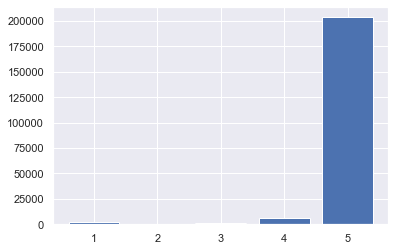

In [28]:
plt.bar(df_2['ratings'].value_counts().index,
       height=df_2['ratings'].value_counts())
plt.yscale('linear')

In [29]:
# Creation of the feature week_day {1:'Monday';...;7:'Sunday'}
df_2['week_day'] = df_2['ratings_date'].apply(lambda x:datetime.isoweekday(x))

In [30]:
# Rating average anc count per week day and ratingType
pd.pivot_table(df_2,
               values='ratings',
               index='week_day',
               columns='ratingType',
               aggfunc=['mean','count'],
               margins=True
               )

mean                                 count                \
ratingType BuyerToSeller SellerToBuyer       All BuyerToSeller SellerToBuyer   
week_day                                                                       
1               4.881410      4.914064  4.901425         11544         18281   
2               4.887834      4.916534  4.905204         11902         18247   
3               4.877986      4.927449  4.907864         12351         18842   
4               4.880825      4.927537  4.908808         11739         17540   
5               4.881714      4.922601  4.906235         12512         18747   
6               4.884234      4.925754  4.909222         12698         19193   
7               4.883145      4.917395  4.903814         12186         18546   
All             4.882447      4.921636  4.906107         84932        129396   

                    
ratingType     All  
week_day            
1            29825  
2            30149  
3            31193  
4            29279  
5            31259  
6            31891  
7            30732  
All         214328

In [31]:
# Group of ratings average per day and ratingType
ratings_por_fecha = pd.pivot_table(df_2,
               values='ratings',
               index='ratings_date',
               columns='ratingType',
               aggfunc=['mean','count'],
               margins=False
               )

ratings_por_fecha

mean                       count              
ratingType   BuyerToSeller SellerToBuyer BuyerToSeller SellerToBuyer
ratings_date                                                        
2021-01-01        4.830904      4.861728           686           810
2021-01-02        4.901747      4.897681           916          1466
2021-01-03        4.863200      4.901813          1250          1986
2021-01-04        4.886145      4.898772          1660          2687
2021-01-05        4.885200      4.896577          1777          2775
2021-01-06        4.893051      4.899396          1842          2813
2021-01-07        4.885425      4.918495          1283          1914
2021-01-08        4.885255      4.936015          1743          2610
2021-01-09        4.866892      4.916945          1773          2697
2021-01-10        4.879159      4.915762          1713          2671
2021-01-11        4.907407      4.912468          1944          3096
2021-01-12        4.875121      4.900221          2074          3167
2021-01-13        4.868447      4.915365          2060          3072
2021-01-14        4.885771      4.924628          2031          3025
2021-01-15        4.899754      4.917740          2035          3027
2021-01-16        4.891641      4.913559          1938          2869
2021-01-17        4.885792      4.900451          1830          2662
2021-01-18        4.893864      4.916925          1809          2901
2021-01-19        4.885729      4.909524          1934          2940
2021-01-20        4.880671      4.940876          2028          3129
2021-01-21        4.888837      4.923622          2159          3247
2021-01-22        4.879110      4.921815          2068          3108
2021-01-23        4.877687      4.913572          1954          3043
2021-01-24        4.869470      4.918316          1831          2779
2021-01-25        4.854564      4.917651          1994          3218
2021-01-26        4.888778      4.927931          1996          3122
2021-01-27        4.867776      4.931750          2163          3326
2021-01-28        4.881044      4.933562          2068          3206
2021-01-29        4.906219      4.925137          2026          3099
2021-01-30        4.870922      4.941081          2115          3072
2021-01-31        4.887559      4.921080          1921          2889
2021-02-01        4.873280      4.912341          2107          3217
2021-02-02        4.891931      4.925703          2082          3163
2021-02-03        4.875973      4.935057          2185          3249
2021-02-04        4.876705      4.935642          1906          2859
2021-02-05        4.873463      4.935867          1952          2947
2021-02-06        4.891944      4.946840          2073          3085
2021-02-07        4.892683      4.921166          1845          2778
2021-02-08        4.876355      4.924099          2030          3162
2021-02-09        4.899951      4.937013          2039          3080
2021-02-10        4.884226      4.938211          2073          3253
2021-02-11        4.869546      4.926421          2292          3289
2021-02-12        4.863636      4.917673          2002          3146
2021-02-13        4.897356      4.934144          1929          2961
2021-02-14        4.897550      4.937792          1796          2781

In [32]:
# Simple linear regression to find trends
coefficients, residuals, _, _, _ = np.polyfit(range(len(ratings_por_fecha.index)),
                                              ratings_por_fecha.iloc[:,0:2],
                                              1,
                                              full=True)

print('Slope SellerToBuyer:', str(coefficients[0,0]),'\nSlope BuyerToSeller:',str(coefficients[0,1]))

Slope SellerToBuyer: 0.00011378966761718772 
Slope BuyerToSeller: 0.0008375221341190565


In [33]:
# Correlation between BuyerToSeller and SellerToBuyer rating average per day
pearson = ratings_por_fecha.iloc[:,0].corr(ratings_por_fecha.iloc[:,1], method='pearson')
print('Pearson correlation: ', round(pearson,2))

Pearson correlation:  0.31


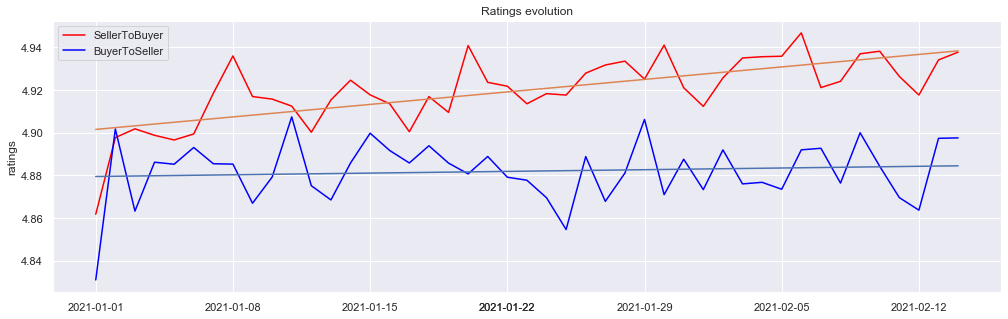

In [34]:
# Evolución de la puntuación promedio diaria según tipo de puntuación

plt.figure(figsize=(17, 5))
plt.plot(ratings_por_fecha.index.astype(str), ratings_por_fecha['mean','SellerToBuyer'], label='SellerToBuyer', color='red')
plt.plot(ratings_por_fecha.index.astype(str), ratings_por_fecha['mean','BuyerToSeller'], label='BuyerToSeller', color='blue')
plt.title('Ratings evolution')
plt.ylabel('ratings')
values = ['2021-01-01','2021-01-08','2021-01-15','2021-01-22','2021-01-22','2021-01-29','2021-02-05','2021-02-12']
plt.xticks(values)
plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(ratings_por_fecha))])
plt.legend()
plt.show()

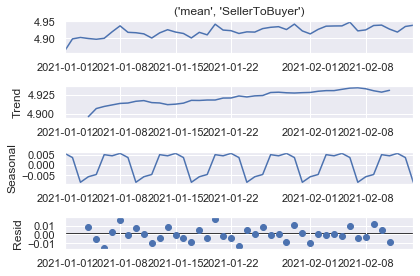

In [35]:
# SellerToBuyer time series decomposition
result = seasonal_decompose(ratings_por_fecha['mean','SellerToBuyer'], model='additive',period=7)
result.plot()
plt.show()

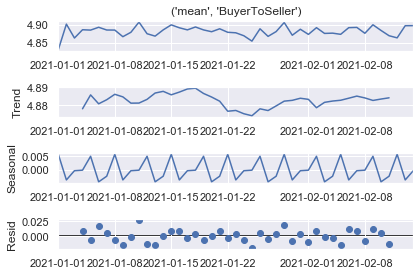

In [36]:
# BuyerToSeller time series decomposition
result = seasonal_decompose(ratings_por_fecha['mean','BuyerToSeller'], model='additive',period=7)
result.plot()
plt.show()

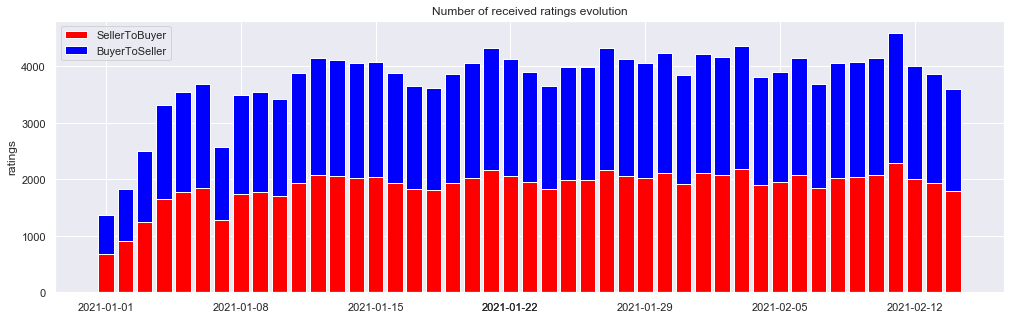

In [37]:
# Evolution of the number of ratings per day and ratingType
plt.figure(figsize=(17, 5))
plt.bar(ratings_por_fecha.index.astype(str), ratings_por_fecha['count','SellerToBuyer'], label='SellerToBuyer', color='red')
plt.bar(ratings_por_fecha.index.astype(str), ratings_por_fecha['count','BuyerToSeller'], bottom=ratings_por_fecha['count','BuyerToSeller'], label='BuyerToSeller', color='blue')
plt.title('Number of received ratings evolution')
plt.ylabel('ratings')
values = ['2021-01-01','2021-01-08','2021-01-15','2021-01-22','2021-01-22','2021-01-29','2021-02-05','2021-02-12']
plt.xticks(values)
plt.legend()
plt.show()

# Exercises

## Exercise 1

### 1. What is the period where these ratings were collected?

In [38]:
print('The ratings were collected between',min(df_2['ratings_date']),'and',max(df_2['ratings_date']))

The ratings were collected between 2021-01-01 00:00:00 and 2021-02-14 00:00:00


### 2. What is the distribution of the number of received ratings per user?

This is the distribution of the number of received ratings per user:


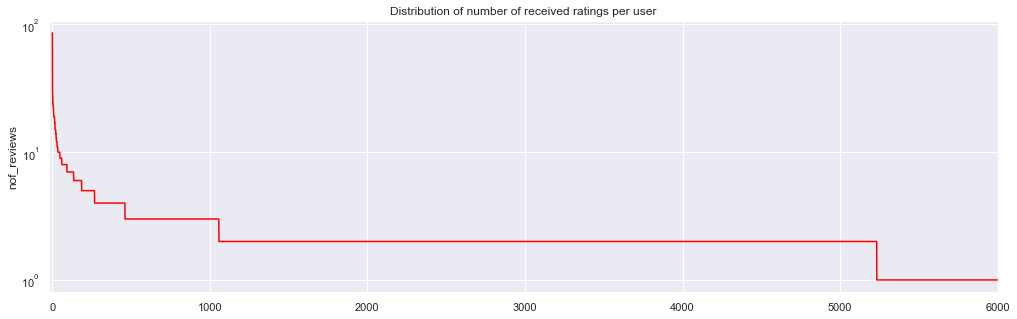

In [39]:
print('This is the distribution of the number of received ratings per user:')
sns.set()
plt.figure(figsize=(17, 5))
plt.plot(df['nof_reviews'], color='red')
plt.xlim(left=-20, right=6000)
plt.title('Distribution of number of received ratings per user')
plt.ylabel('nof_reviews')
plt.yscale('log')
plt.show()

In [40]:
df['nof_reviews'].value_counts()/sum(df['nof_reviews'].value_counts())*100

1     97.464583
2      2.022811
3      0.288765
4      0.093510
5      0.039729
6      0.024710
7      0.020349
8      0.015989
10     0.006299
9      0.005814
19     0.002423
15     0.002423
11     0.002423
12     0.001938
13     0.000969
14     0.000969
17     0.000969
23     0.000969
24     0.000969
85     0.000485
18     0.000485
20     0.000485
22     0.000485
28     0.000485
29     0.000485
86     0.000485
Name: nof_reviews, dtype: float64

In [41]:
df_reviews['nof_reviews'].value_counts()/sum(df_reviews['nof_reviews'].value_counts())*100

2     79.782152
3     11.389260
4      3.688133
5      1.566979
6      0.974584
7      0.802599
8      0.630613
10     0.248423
9      0.229314
11     0.095547
15     0.095547
19     0.095547
12     0.076438
13     0.038219
24     0.038219
23     0.038219
17     0.038219
14     0.038219
85     0.019109
28     0.019109
18     0.019109
20     0.019109
22     0.019109
86     0.019109
29     0.019109
Name: nof_reviews, dtype: float64

### 3. What is the average of the rating value?

In [42]:
print('Average rating per user:', round(user_avg_rating, 4),
     '\nAverage rating per transaction:', round(transaction_avg_rating, 4))

Average rating per user: 4.9047 
Average rating per transaction: 4.9061


### 4. What differences are there between ratings SellerToBuyer and BuyerToSeller?

In [43]:
df_2[['ratingType','ratings']].groupby(by='ratingType').mean()

,ratings
ratingType,
BuyerToSeller,4.882447
SellerToBuyer,4.921636


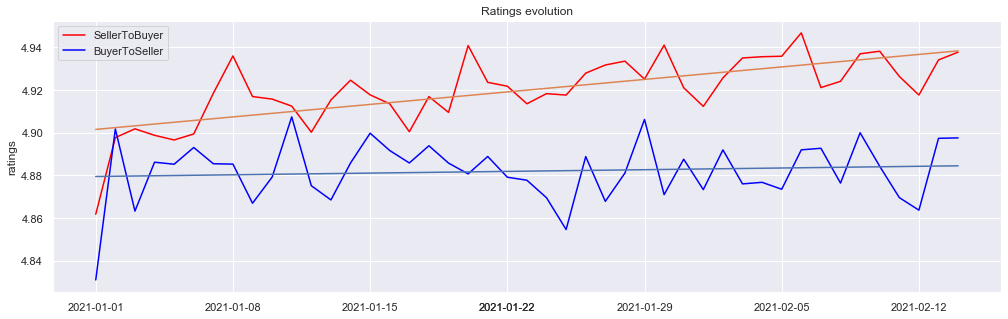

In [44]:
plt.figure(figsize=(17, 5))
plt.plot(ratings_por_fecha.index.astype(str), ratings_por_fecha['mean','SellerToBuyer'], label='SellerToBuyer', color='red')
plt.plot(ratings_por_fecha.index.astype(str), ratings_por_fecha['mean','BuyerToSeller'], label='BuyerToSeller', color='blue')
plt.title('Ratings evolution')
plt.ylabel('ratings')
values = ['2021-01-01','2021-01-08','2021-01-15','2021-01-22','2021-01-22','2021-01-29','2021-02-05','2021-02-12']
plt.xticks(values)
plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(ratings_por_fecha))])
plt.legend()
plt.show()

## Exercise 3

In [45]:
df['score'] = (df['nof_reviews'].apply(log)+1) * df['rating_avg']

In [46]:
df['score'].describe()

count    206396.000000
mean          5.008769
std           0.867279
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          27.271736
Name: score, dtype: float64

In [47]:
df[df['ratingType']=='BuyerToSeller'].sort_values(by='score', ascending=False).head()

,ratingType,ratings,ratings_date,nof_reviews,rating_avg,max_rating,min_rating,max_date,min_date,score<5,>1review,date_range,rating_range,days_range,ratings_per_day,score
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.236842,27.213256
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29,5.0,5,5,2021-02-13,2021-01-01,False,True,43 days,0,43,0.674419,21.836479
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24,5.0,5,5,2021-02-06,2021-01-17,False,True,20 days,0,20,1.200000,20.890269
6,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-26, 2021-02-08, 2021-02-08, 2021-01-1...",23,5.0,5,5,2021-02-12,2021-01-11,False,True,32 days,0,32,0.718750,20.677471
9,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-21, 2021-01-21, 2021-01-21, 2021-01-2...",20,5.0,5,5,2021-01-28,2021-01-01,False,True,27 days,0,27,0.740741,19.978661


In [48]:
df[df['ratingType']=='SellerToBuyer'].sort_values(by='score', ascending=False).head()

,ratingType,ratings,ratings_date,nof_reviews,rating_avg,max_rating,min_rating,max_date,min_date,score<5,>1review,date_range,rating_range,days_range,ratings_per_day,score
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,5.0,5,5,2021-02-14,2021-01-07,False,True,38 days,0,38,2.263158,27.271736
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28,5.0,5,5,2021-02-12,2021-01-01,False,True,42 days,0,42,0.666667,21.661023
5,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-28, 2021-01-19, 2021-01-19, 2021-01-1...",24,5.0,5,5,2021-02-06,2021-01-17,False,True,20 days,0,20,1.200000,20.890269
7,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-25, 2021-02-08, 2021-02-08, 2021-01-2...",23,5.0,5,5,2021-02-12,2021-01-11,False,True,32 days,0,32,0.718750,20.677471
8,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-10, 2021-01-19, 2021-01-15, 2021-01-1...",22,5.0,5,5,2021-02-14,2021-01-08,False,True,37 days,0,37,0.594595,20.455212
